In [1]:
## Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, accuracy_score, \
                            precision_recall_curve, f1_score, fbeta_score, roc_auc_score, roc_curve, fbeta_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from mlxtend.plotting import plot_decision_regions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.pipeline import make_pipeline, Pipeline


Using TensorFlow backend.
/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hellojenny/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

# Set up some foundations: features, target, and train/test split

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
df.default

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default, Length: 30000, dtype: int64

In [4]:
df.columns

Index(['credit_line', 'sex', 'education', 'marriage', 'age', 'status_2005_04',
       'status_2005_05', 'status_2005_06', 'status_2005_07', 'status_2005_08',
       'status_2005_09', 'bill_2005_09', 'bill_2005_08', 'bill_2005_07',
       'bill_2005_06', 'bill_2005_05', 'bill_2005_04', 'payment_2005_09',
       'payment_2005_08', 'payment_2005_07', 'payment_2005_06',
       'payment_2005_05', 'payment_2005_04', 'default',
       'cerdit_line_total_usage', 'status_delayed_04', 'status_delayed_05',
       'status_delayed_06', 'status_delayed_07', 'status_delayed_08',
       'status_delayed_09', 'payment_was_delayed', 'status_delayed_sum',
       'education_Graduate School', 'education_High School',
       'education_Others', 'education_University', 'birth_year', 'generation',
       'age_Gen X', 'age_Millennials', 'age_Silent Gen'],
      dtype='object')

# Train/Test Split: 80:20

In [5]:
## This is for cross validation
X_original = df[['education_Graduate School', 'education_University', 'education_High School', 'education_Others',
                 'cerdit_line_total_usage', 'status_delayed_sum']]
y_original = df['default']


X, X_test, y, y_test = train_test_split(X_original, y_original, test_size = 0.2, random_state = 42, stratify=y_original)

In [6]:
X.shape

(24000, 6)

# Apply validation method: Train/Test Split: 60:20:20

In [7]:
## This is for simple validation split 60:20:20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

In [8]:
train_df = X_train.copy()
train_df['default'] = y_train
target_count = y_train.value_counts()

# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count)*100, 4)}%')

Class 0: 14018
Class 1: 3982
Proportion: 3.52 : 1
Percentage of Majority Class: 77.8778%


# Create Custom Functions

In [9]:
def cm_chart_with_threshold(model, X, y, threshold):
    # Numbers for the confuion matrix
    plt.figure(figsize=(10, 7))
    plt.title("Confusion Matrix\n")
    feature = X
    y_proba = model.predict_proba(feature)[:, 1]
    y_pred = (y_proba >= threshold)
    cm = confusion_matrix(y, y_pred)

    # Set up the labels for in the confusion matrix
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n({v3})' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Paid', 'Default']
    
    # Create confusion matrix as heatmap
    sns.set(font_scale = 1.2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xlabel("Predicted", size=15)
    plt.ylabel("Actual", size=15);
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '\n\nAccuracy = {:.2%}\nPrecision = {:.2%}\nRecall = {:.2%}\nSpecificity = {:.2%}\nF1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [10]:
def curves(model, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(20, 5))
    
    # ROC Curve
    plt.subplot(1, 3, 1)
    model.fit(X, y)
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for Credit Card Default');
    print("ROC AUC score = ", roc_auc_score(y_test, y_proba))
    
    # Precision and Recall Curves
    plt.subplot(1, 3, 2)
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_proba)
    
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (Probablity)')
    plt.title('Precision and Recall Curves');
    
    # Precision and Recall Curves
    plt.subplot(1, 3, 3)
    plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve");

In [11]:
def model_score(model, X, y):
    skf = StratifiedKFold(5, random_state=42, shuffle=True)
    scores = cross_validate(model, X, y, cv=skf, 
                            scoring=['recall', 'precision', 'accuracy', 'f1', 'balanced_accuracy', 'roc_auc'], 
                            return_estimator=True)
    score_types = ['test_recall', 'test_precision', 'test_accuracy', 
                   'test_balanced_accuracy', 'test_f1', 'test_roc_auc']
    score_dict = {}
    for score_type in score_types:
        score_dict['{0}_mean'.format(score_type)] = str(round((np.mean(scores[score_type])*100),2)) + "%"
        score_dict['{0}_std'.format(score_type)] = str(round((np.std(scores[score_type])*100),2)) + "%"
    return score_dict

In [12]:
def pipeline_score(pipeline, X, y):
    skf = StratifiedKFold(5, random_state=42, shuffle=True)
    scores = cross_validate(pipeline, X, y, cv=skf,
                            scoring=['recall', 'precision', 'accuracy', 'f1', 'balanced_accuracy', 'roc_auc'],
                            return_estimator=True) 
    score_types = ['test_recall', 'test_precision', 'test_accuracy', 
                   'test_balanced_accuracy', 'test_f1', 'test_roc_auc']
    score_dict = {}
    for score_type in score_types:
        score_dict['{0}_mean'.format(score_type)] = str(round((np.mean(scores[score_type])*100),2)) + "%"
        score_dict['{0}_std'.format(score_type)] = str(round((np.std(scores[score_type])*100),2)) + "%"
    return score_dict

# Fix Imbalanced Data

## Without Applying Any Class Imbalanced Methods

In [13]:
pipeline = make_pipeline(MinMaxScaler(), 
                         LogisticRegression())
pipeline_score(pipeline, X, y)

{'test_recall_mean': '24.96%',
 'test_recall_std': '0.94%',
 'test_precision_mean': '64.27%',
 'test_precision_std': '2.62%',
 'test_accuracy_mean': '80.32%',
 'test_accuracy_std': '0.42%',
 'test_balanced_accuracy_mean': '60.5%',
 'test_balanced_accuracy_std': '0.57%',
 'test_f1_mean': '35.95%',
 'test_f1_std': '1.28%',
 'test_roc_auc_mean': '73.73%',
 'test_roc_auc_std': '1.3%'}

## Class Imbalanced Method #1: Random Oversampling

In [14]:
pipeline = make_pipeline(MinMaxScaler(),
                         RandomOverSampler(random_state=42), 
                         LogisticRegression(C=1, solver='liblinear'))
pipeline_score(pipeline, X, y)

{'test_recall_mean': '52.04%',
 'test_recall_std': '1.47%',
 'test_precision_mean': '50.11%',
 'test_precision_std': '1.17%',
 'test_accuracy_mean': '77.93%',
 'test_accuracy_std': '0.54%',
 'test_balanced_accuracy_mean': '68.66%',
 'test_balanced_accuracy_std': '0.83%',
 'test_f1_mean': '51.06%',
 'test_f1_std': '1.24%',
 'test_roc_auc_mean': '73.72%',
 'test_roc_auc_std': '1.26%'}

## Class Imbalanced Method #2: SMOTE

In [15]:
pipeline = make_pipeline(MinMaxScaler(),
                         SMOTE(random_state=42),  
                         LogisticRegression(C=1, solver='liblinear'))
pipeline_score(pipeline, X, y)

{'test_recall_mean': '51.95%',
 'test_recall_std': '1.27%',
 'test_precision_mean': '50.14%',
 'test_precision_std': '1.25%',
 'test_accuracy_mean': '77.94%',
 'test_accuracy_std': '0.58%',
 'test_balanced_accuracy_mean': '68.63%',
 'test_balanced_accuracy_std': '0.76%',
 'test_f1_mean': '51.02%',
 'test_f1_std': '1.16%',
 'test_roc_auc_mean': '73.73%',
 'test_roc_auc_std': '1.28%'}

## Class Imbalanced Method #3: ADASYN

In [16]:
pipeline = make_pipeline(MinMaxScaler(), 
                         ADASYN(random_state=42), 
                         LogisticRegression(C=1, solver='liblinear'))
pipeline_score(pipeline, X, y)

{'test_recall_mean': '59.9%',
 'test_recall_std': '1.03%',
 'test_precision_mean': '46.05%',
 'test_precision_std': '1.15%',
 'test_accuracy_mean': '75.6%',
 'test_accuracy_std': '0.71%',
 'test_balanced_accuracy_mean': '69.98%',
 'test_balanced_accuracy_std': '0.74%',
 'test_f1_mean': '52.06%',
 'test_f1_std': '1.03%',
 'test_roc_auc_mean': '73.71%',
 'test_roc_auc_std': '1.27%'}

**Conclusion: We'll apply ADASYN as it gives the best Recall score**

In [17]:
## Oversampling on the data for simple validation split 60:20:20
X_train, y_train = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)

# Model #1: K-nearest Neighbor

In [18]:
pipeline = make_pipeline(MinMaxScaler(),
                         ADASYN(random_state=42),  
                         KNeighborsClassifier(n_neighbors=5))
pipeline_score(pipeline, X, y)

{'test_recall_mean': '60.48%',
 'test_recall_std': '0.71%',
 'test_precision_mean': '33.35%',
 'test_precision_std': '0.93%',
 'test_accuracy_mean': '64.49%',
 'test_accuracy_std': '1.07%',
 'test_balanced_accuracy_mean': '63.06%',
 'test_balanced_accuracy_std': '0.74%',
 'test_f1_mean': '42.99%',
 'test_f1_std': '0.81%',
 'test_roc_auc_mean': '66.77%',
 'test_roc_auc_std': '0.43%'}

# Model #2: Logistic Regression

1) Finding the best hyperparameter

In [19]:
lr = Pipeline([('scaling', MinMaxScaler()),
               ('sampling', ADASYN(random_state=42)),
               ('classification', LogisticRegression())])

params = {'classification__penalty': ['l1'],
          'classification__C': 10**np.linspace(-4,-2,10), ## the smaller C is, the steeper the slope is for logistic regression
          'classification__solver': ['liblinear']}
clf = GridSearchCV(lr, param_grid=params, cv=5, scoring='recall', verbose=2, n_jobs=-1)
best_model = clf.fit(X, y)
best_model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.7s finished


{'classification__C': 0.01,
 'classification__penalty': 'l1',
 'classification__solver': 'liblinear'}

2) Check the score

In [20]:
pipeline = make_pipeline(MinMaxScaler(),
                         ADASYN(random_state=42),  
                         LogisticRegression(solver='liblinear', C=0.00129, penalty='l1'))
pipeline_score(pipeline, X, y)

{'test_recall_mean': '65.53%',
 'test_recall_std': '1.19%',
 'test_precision_mean': '42.95%',
 'test_precision_std': '1.22%',
 'test_accuracy_mean': '73.1%',
 'test_accuracy_std': '0.92%',
 'test_balanced_accuracy_mean': '70.39%',
 'test_balanced_accuracy_std': '0.92%',
 'test_f1_mean': '51.88%',
 'test_f1_std': '1.18%',
 'test_roc_auc_mean': '72.94%',
 'test_roc_auc_std': '0.85%'}

3) Create Feature Importace Chart

In [21]:
lr = Pipeline([('scaling', MinMaxScaler()),
               ('sampling', ADASYN(random_state=42)),
               ('classification', LogisticRegression(solver='liblinear', C=1, penalty='l1'))])

coef = lr.fit(X, y)[-1].coef_.ravel()
lr_feature_df = pd.DataFrame({'Feature': X.columns, 'coef': coef})
lr_feature_df['color'] = lr_feature_df['coef'].apply(lambda x: 'Green' if x >= 0 else 'Red')
lr_feature_df = lr_feature_df.sort_values(by=['coef'], ascending=False).reset_index(drop = True)
lr_feature_df

,Feature,coef,color
0,status_delayed_sum,2.746272,Green
1,education_High School,0.745165,Green
2,education_University,0.741054,Green
3,education_Graduate School,0.669483,Green
4,cerdit_line_total_usage,0.592832,Green
5,education_Others,-0.004926,Red


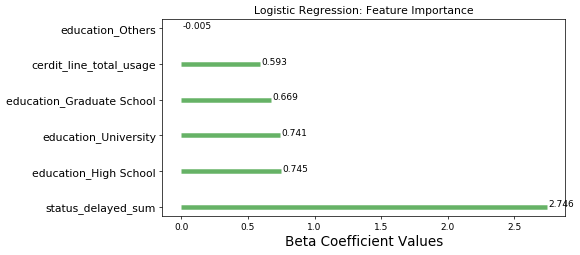

In [22]:
plt.figure(figsize=(8, 4), dpi=65)
plt.title("Logistic Regression: Feature Importance")
plt.hlines(y=lr_feature_df.index, 
           xmin=0, xmax=lr_feature_df['coef'],
           color=lr_feature_df['color'], alpha=0.6, linewidth=5)

plt.xlabel(xlabel = 'Beta Coefficient Values', size = 15)

plt.yticks(lr_feature_df.index, lr_feature_df['Feature'], fontsize=12)

for index, value in enumerate(lr_feature_df.coef):
    plt.text(value+0.01, index, round(value, 3))
    
    ## log odds of you defaulting goes up by 0.377

4) Plot ROC Curve

Logistic Regression
ROC AUC score =  0.7180953096650563


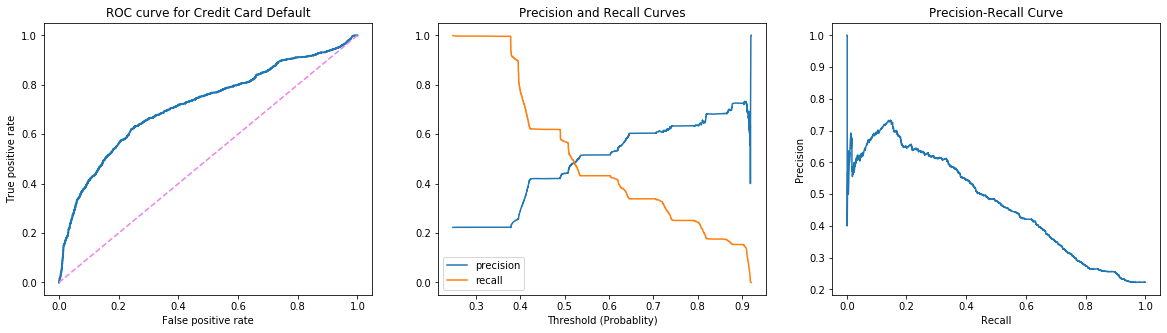

In [23]:
print("Logistic Regression")
curves(lr, X, y, X_test, y_test)

# Model #3: Random Forest

1) Finding the best hyperparameter

In [24]:
rf = Pipeline([('scaling', MinMaxScaler()),
                ('sampling', ADASYN(random_state=42)),
                ('classification', RandomForestClassifier())])

param_grid = {'classification__max_depth': [7,8], 
              'classification__min_samples_split': [7, 8]}

skf = StratifiedKFold(5, random_state=42, shuffle=True)

clf = GridSearchCV(rf, param_grid = param_grid, 
                   n_jobs = -1, verbose = 2, scoring='recall', cv=skf)
best_model = clf.fit(X, y)
best_params = clf.best_params_
best_params

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    3.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.9s finished


{'classification__max_depth': 7, 'classification__min_samples_split': 8}

2) Check the scores

In [25]:
pipeline = make_pipeline(MinMaxScaler(),
                         ADASYN(random_state=42),  
                         RandomForestClassifier(bootstrap=True, max_depth = 7, min_samples_split=7))
pipeline_score(pipeline, X, y)

{'test_recall_mean': '67.24%',
 'test_recall_std': '0.99%',
 'test_precision_mean': '41.95%',
 'test_precision_std': '0.69%',
 'test_accuracy_mean': '72.16%',
 'test_accuracy_std': '0.54%',
 'test_balanced_accuracy_mean': '70.4%',
 'test_balanced_accuracy_std': '0.61%',
 'test_f1_mean': '51.66%',
 'test_f1_std': '0.74%',
 'test_roc_auc_mean': '75.68%',
 'test_roc_auc_std': '0.62%'}

3) Create Feature Importace Chart

In [26]:
rf = Pipeline([('scaling', MinMaxScaler()),
               ('sampling', ADASYN(random_state=42)),
               ('classification', RandomForestClassifier(bootstrap=True, max_depth = 7, min_samples_split=7))])

rf.fit(X, y)
rf_feature_df = pd.DataFrame(rf.named_steps['classification'].feature_importances_,
                             index=X.columns,
                             columns=['importance']).sort_values('importance', ascending=False)
rf_feature_df

,importance
status_delayed_sum,0.705735
cerdit_line_total_usage,0.268144
education_Graduate School,0.009192
education_University,0.007312
education_High School,0.005703
education_Others,0.003914


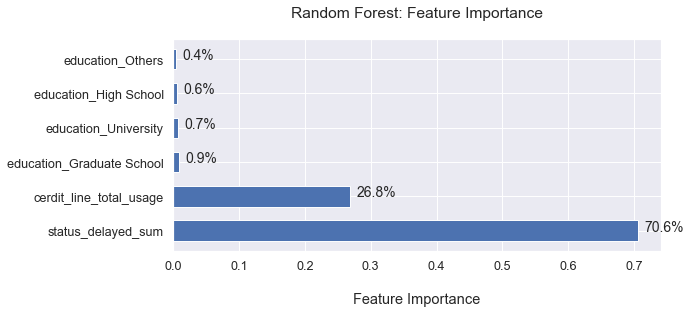

In [54]:
plt.figure(figsize=(9, 4), dpi=70)
plt.title("Random Forest: Feature Importance\n", size=16)
plt.barh(rf_feature_df.index, rf_feature_df.importance, height=0.6)
plt.xlabel("\nFeature Importance", size=15)
plt.xticks(size=13)
plt.yticks(size=13)

for index, value in enumerate(rf_feature_df.importance):
    value_str = str(round(value*100, 1)) + "%"
    plt.text(value+0.01, index, value_str)

4) Plot ROC Curve

ROC AUC score =  0.7481408453475213


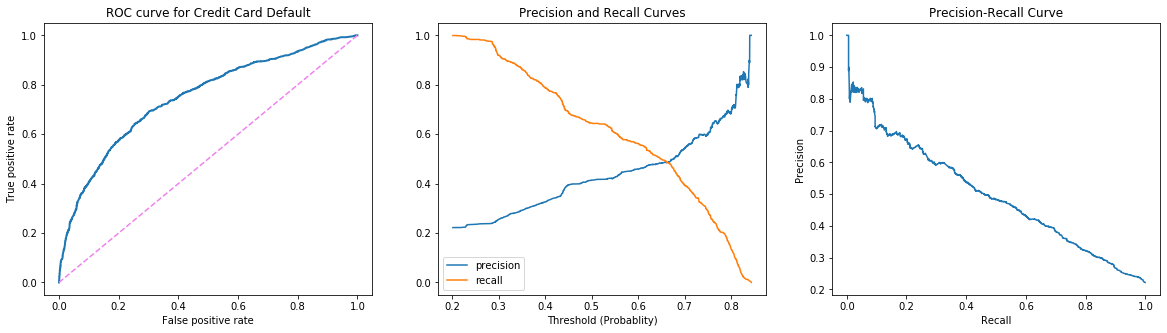

In [28]:
curves(rf, X, y, X_test, y_test)

# Model #4: Extra Trees

**1) Finding the Best Hyperparameter**

In [29]:
et = Pipeline([('scaling', MinMaxScaler()),
               ('sampling', ADASYN(random_state=42)),
               ('classification', ExtraTreesClassifier(bootstrap=True))])

param_grid = {'classification__max_depth': [5, 6, 7],
              'classification__min_samples_split': [6, 7, 8],
              'classification__n_estimators': [100, 200, 500]}

clf = GridSearchCV(et, param_grid = param_grid, cv=5, n_jobs = -1, verbose = 2, scoring='recall')
best_model = clf.fit(X_train, y_train)
best_params = clf.best_params_
best_params

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s


KeyboardInterrupt: 

**2) Check the Scores**

In [30]:
pipeline = make_pipeline(MinMaxScaler(),
                         ADASYN(random_state=42),  
                         ExtraTreesClassifier(max_depth = 5, min_samples_split=6, bootstrap=True, n_estimators=100))
pipeline_score(pipeline, X, y)

{'test_recall_mean': '65.34%',
 'test_recall_std': '1.17%',
 'test_precision_mean': '43.2%',
 'test_precision_std': '1.25%',
 'test_accuracy_mean': '73.31%',
 'test_accuracy_std': '0.94%',
 'test_balanced_accuracy_mean': '70.46%',
 'test_balanced_accuracy_std': '0.9%',
 'test_f1_mean': '52.0%',
 'test_f1_std': '1.17%',
 'test_roc_auc_mean': '75.0%',
 'test_roc_auc_std': '1.09%'}

**3) Create the Feature Importance Chart**

In [31]:
et = Pipeline([('scaling', MinMaxScaler()),
               ('sampling', ADASYN(random_state=42)),
               ('classification', ExtraTreesClassifier(bootstrap=True, 
                                                       max_depth = 5, 
                                                       min_samples_split=6))])

et.fit(X, y)

et_feature_df = pd.DataFrame(et.steps[2][1].feature_importances_, 
                             index=X.columns,
                             columns=['importance']).sort_values('importance', ascending=False)
et_feature_df

,importance
status_delayed_sum,0.921820
cerdit_line_total_usage,0.042819
education_Graduate School,0.012639
education_High School,0.008724
education_University,0.008000
education_Others,0.005998


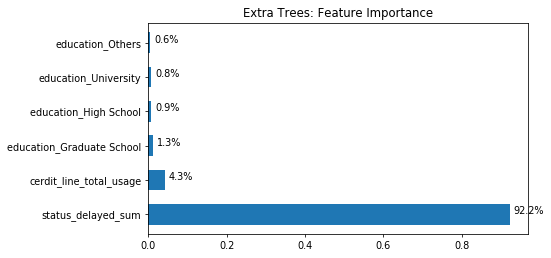

In [32]:
plt.figure(figsize=(7, 4), dpi=70)
plt.title("Extra Trees: Feature Importance")
plt.barh(et_feature_df.index, et_feature_df.importance, height=0.6)

for index, value in enumerate(et_feature_df.importance):
    value_str = str(round(value*100, 1)) + "%"
    plt.text(value+0.01, index, value_str)

**4) Plot the ROC Curve, Precision & Recall Curves, and Precision-Recall Curve**

ROC AUC score =  0.7359019917688413


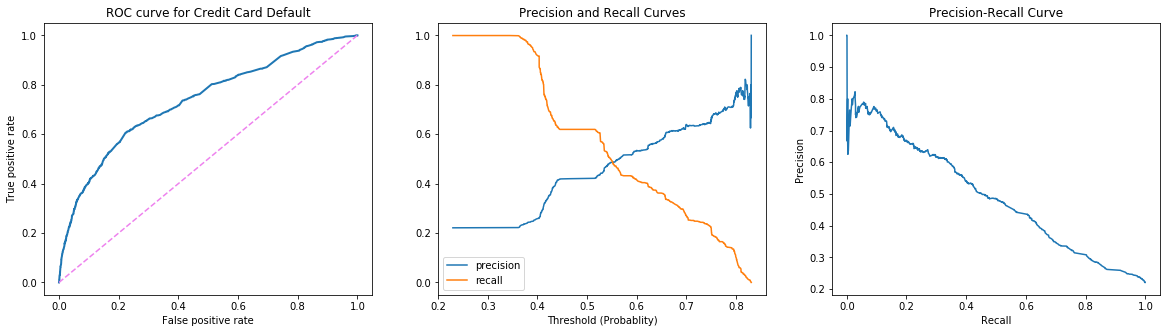

In [33]:
curves(et, X, y, X_test, y_test)

## Model #5: Linear SVC

In [34]:
pipeline = make_pipeline(MinMaxScaler(),
                         ADASYN(random_state=42),  
                         LinearSVC(C=1, random_state=42, dual=False))
pipeline_score(pipeline, X, y)

{'test_recall_mean': '53.4%',
 'test_recall_std': '1.54%',
 'test_precision_mean': '49.57%',
 'test_precision_std': '1.04%',
 'test_accuracy_mean': '77.68%',
 'test_accuracy_std': '0.5%',
 'test_balanced_accuracy_mean': '68.99%',
 'test_balanced_accuracy_std': '0.82%',
 'test_f1_mean': '51.41%',
 'test_f1_std': '1.2%',
 'test_roc_auc_mean': '73.69%',
 'test_roc_auc_std': '1.28%'}

# Model #6: Naive Bayes - Gaussian

In [35]:
pipeline = make_pipeline(MinMaxScaler(),
                         ADASYN(random_state=42),  
                         GaussianNB())
pipeline_score(pipeline, X, y)

{'test_recall_mean': '70.24%',
 'test_recall_std': '10.26%',
 'test_precision_mean': '33.59%',
 'test_precision_std': '5.13%',
 'test_accuracy_mean': '60.15%',
 'test_accuracy_std': '12.51%',
 'test_balanced_accuracy_mean': '63.76%',
 'test_balanced_accuracy_std': '4.39%',
 'test_f1_mean': '44.61%',
 'test_f1_std': '3.37%',
 'test_roc_auc_mean': '71.1%',
 'test_roc_auc_std': '1.09%'}

# Model #7: Naive Bayes - Bernoulli

In [36]:
pipeline = make_pipeline(MinMaxScaler(),
                         ADASYN(random_state=42),  
                         BernoulliNB())
pipeline_score(pipeline, X, y)

{'test_recall_mean': '65.53%',
 'test_recall_std': '1.19%',
 'test_precision_mean': '43.03%',
 'test_precision_std': '1.22%',
 'test_accuracy_mean': '73.17%',
 'test_accuracy_std': '0.92%',
 'test_balanced_accuracy_mean': '70.44%',
 'test_balanced_accuracy_std': '0.92%',
 'test_f1_mean': '51.95%',
 'test_f1_std': '1.18%',
 'test_roc_auc_mean': '71.48%',
 'test_roc_auc_std': '1.1%'}

# Best Model Goes to ... Random Forest!

## Ensembling? 

Plot ROC-AUC Curve for the Top 3 Models and we figured that since Random Forest still performs the best and doesn't have much overlap with other models. Other models will only be performing better in very little areas, hence we won't be ensembling.

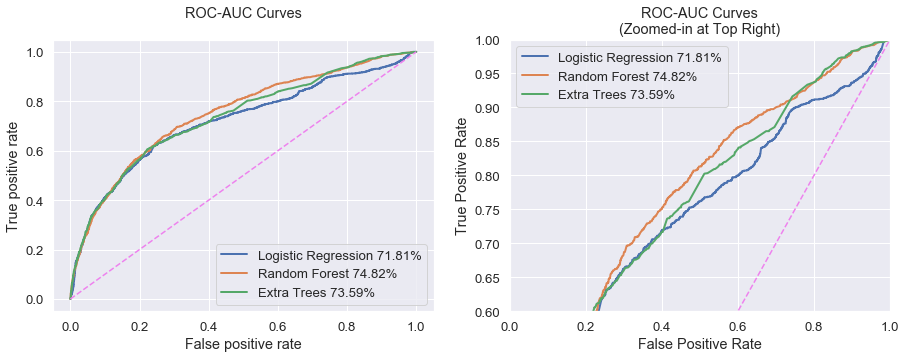

In [43]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

plt.figure(figsize=(15, 5))

## plot #1
plt.subplot(1, 2, 1)

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
score = str(round(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])*100, 2)) + "%"
plt.plot(fpr, tpr,lw=2, label='Logistic Regression %s' % score)

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
score = str(round(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])*100, 2)) + "%"
plt.plot(fpr, tpr,lw=2, label='Random Forest %s' % score)

fpr, tpr, thresholds = roc_curve(y_test, et.predict_proba(X_test)[:,1])
score = str(round(roc_auc_score(y_test, et.predict_proba(X_test)[:,1])*100, 2)) + "%"
plt.plot(fpr, tpr,lw=2, label='Extra Trees %s' % score)

plt.legend()
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-AUC Curves\n');

## plot #2
plt.subplot(1, 2, 2)

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
score = str(round(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])*100, 2)) + "%"
plt.plot(fpr, tpr,lw=2, label='Logistic Regression %s' % score)

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
score = str(round(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])*100, 2)) + "%"
plt.plot(fpr, tpr,lw=2, label='Random Forest %s' % score)

fpr, tpr, thresholds = roc_curve(y_test, et.predict_proba(X_test)[:,1])
score = str(round(roc_auc_score(y_test, et.predict_proba(X_test)[:,1])*100, 2)) + "%"
plt.plot(fpr, tpr, lw=2, label='Extra Trees %s' % score)

plt.legend()
plt.xlim(0, 1)
plt.ylim(0.6, 1)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves\n(Zoomed-in at Top Right)');

## Find the best threshold

In [38]:
rf.fit(X, y)
y_proba = rf.named_steps['classification'].predict_proba(X_test)[:, 1]
threshold_dict = {}
thresholds = [round(index, 4) for index in np.linspace(0,1,10000)]
for threshold in thresholds:
    #anything above or equal to the threshold is 1
    #anything below the threshold is 0
    y_pred = (y_proba >= threshold)
    f2_score = fbeta_score(y_test, y_pred, 2)
    threshold_dict[threshold] = f2_score

optimal_threshold = max(threshold_dict, key=threshold_dict.get)
print("Optimal Threshold:", optimal_threshold)

y_pred = (y_proba >= optimal_threshold)
f2_score = fbeta_score(y_test, y_pred, 2)
print("F2 Score:", f2_score)

Optimal Threshold: 0.3294
F2 Score: 0.5970609392662626


## Test the model on the hold-out set



Accuracy = 35.38%
Precision = 24.78%
Recall = 94.42%
Specificity = 18.62%
F1 Score = 39.26%


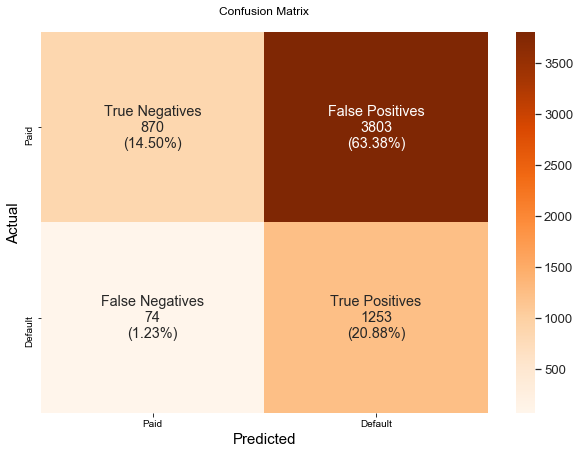

In [39]:
final_model = make_pipeline(MinMaxScaler(),
                            ADASYN(random_state=42),  
                            RandomForestClassifier(bootstrap=True, max_depth = 7, 
                                                   min_samples_split=7, n_jobs = -1))
 
final_model.fit(X, y)
cm_chart_with_threshold(final_model, X_test, y_test, 0.3019)



Accuracy = 70.28%
Precision = 39.83%
Recall = 67.29%
Specificity = 71.13%
F1 Score = 50.04%


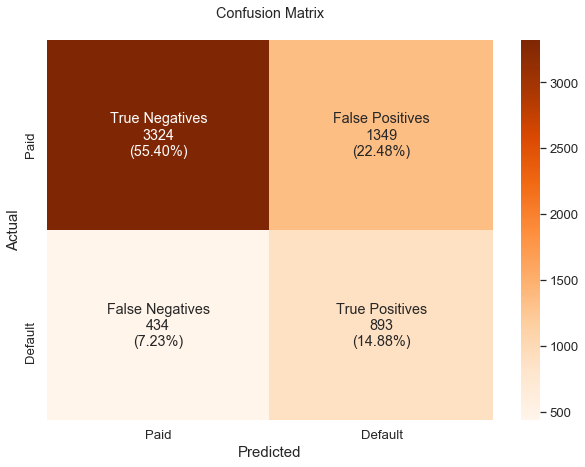

In [40]:
cm_chart_with_threshold(final_model, X_test, y_test, 0.465)